In [1]:
import os
import sys
import random
import math
import re

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize

### Global Constants

In [2]:
ROOT_DIR = os.path.abspath("./")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

### Configuring the Mask R-CNN Model for Durian Locule Counting

Note: The BACKBONE can be changed either ResNet50, ResNet101.

In [4]:
class LoculesConfig(Config):
    NAME = "locules"
    BACKBONE = "resnet101"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2 + 1
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0001

config = LoculesConfig()
config.display()
    


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        35
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

### Prepare the dataset which is in COCO format

To download the dataset, it would be useful to invoke the `download_dataset.py` script which downloads the dataset from Roboflow. The dataset is in COCO format.

In [ ]:
from utils.custom_dataset import DurianLoculeDataset

dataset_train = DurianLoculeDataset()
dataset_train.load_data('./dataset/train/_annotations.coco.json', './dataset/train/')
dataset_train.prepare()

dataset_val = DurianLoculeDataset()
dataset_val.load_data('./dataset/valid/_annotations.coco.json', './dataset/valid/')
dataset_val.prepare()

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    
dataset = dataset_val
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

### Load the weights of the Mask R-CNN model

The weights of the Mask R-CNN model can be loaded from the `mask_rcnn_coco.h5` file. The weights are pre-trained on the COCO dataset.

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Train from coco checkpoint
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

### Training the Mask R-CNN model

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')

## Performance Metrics which is used to evaluate the model:

- mAP@0.5
- mAP@0.75
- mAP@0.5-0.95
- mIoU

In [ ]:
import os
import re

mask_rcnn_pattern = r'^mask_rcnn.*\.h5$'
home_dir = os.getcwd()

# Get the first item in the MODEL_DIR
latest_log_dir = os.listdir(MODEL_DIR)[1]  # Change to 0
directory_content = os.listdir(os.path.join(MODEL_DIR, latest_log_dir))

# Search for files matching the mask_rcnn pattern
matching_files = [f for f in directory_content if re.search(mask_rcnn_pattern, f)]

# Check if there are any matching files
if matching_files:
    latest_weight = matching_files[-1]
    print("Latest matching file:", latest_weight)

    # Construct the full path to the latest weight file
    latest_weight_dir = os.path.join(MODEL_DIR, latest_log_dir, latest_weight)
    print("Latest weight file path:", latest_weight_dir)
else:
    print("No matching files found.")


In [5]:
from mrcnn.utils import compute_ap, compute_ap_range

from utils.custom_dataset import DurianLoculeDataset

TEST_DATASET_JSON = "./dataset/test/_annotations.coco.json"
TEST_DATASET_DIR = "./dataset/test/"
# TRAINED_MODEL_WEIGHTS_PATH = latest_weight_dir
# TRAINED_MODEL_WEIGHTS_PATH="/app/logs/locules20250215T0937/mask_rcnn_locules_0010.h5"
TRAINED_MODEL_WEIGHTS_PATH="/app/mask_rcnn_locules_0080.h5"


dataset_test = DurianLoculeDataset()
dataset_test.load_data(TEST_DATASET_JSON, TEST_DATASET_DIR)
dataset_test.prepare()

test_config = LoculesConfig()
test_model = modellib.MaskRCNN(mode="inference", config=test_config, model_dir=MODEL_DIR)
test_model.load_weights(TRAINED_MODEL_WEIGHTS_PATH, by_name=True)

Instructions for updating:
Use fn_output_signature instead


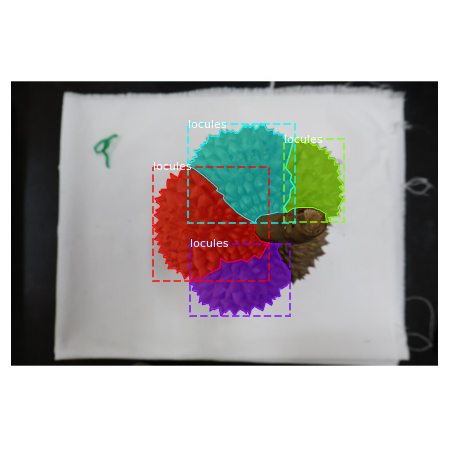

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


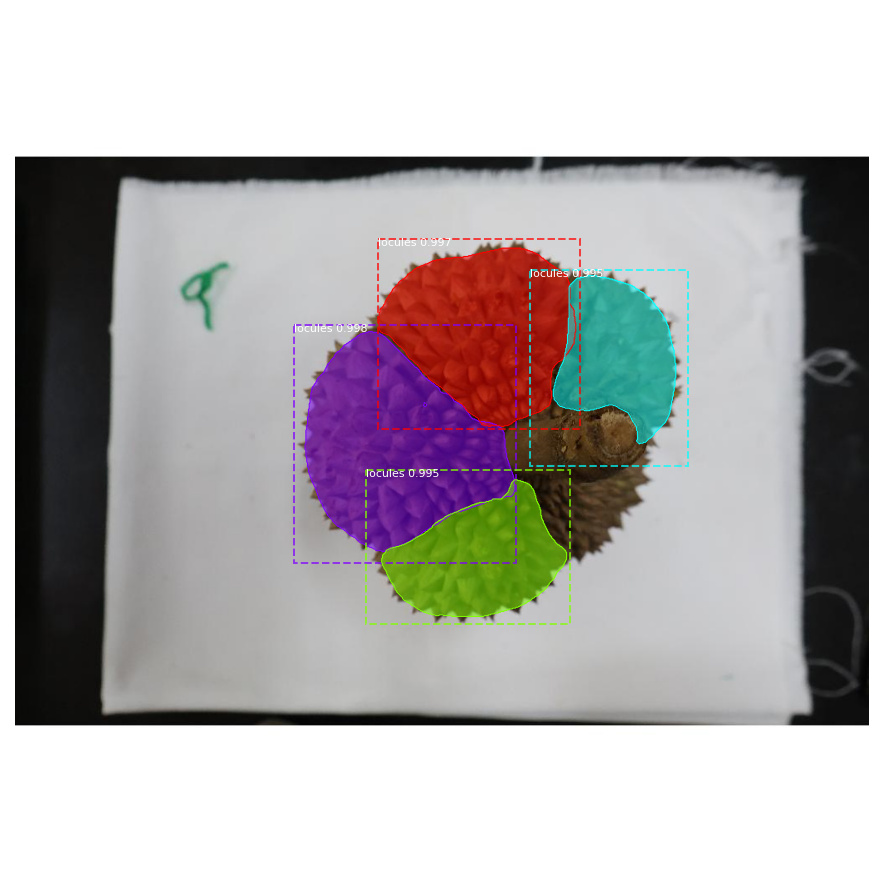

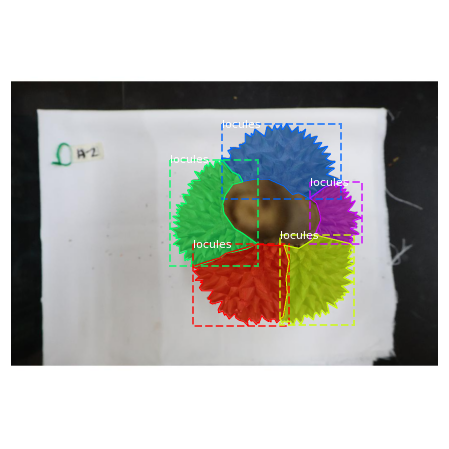

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


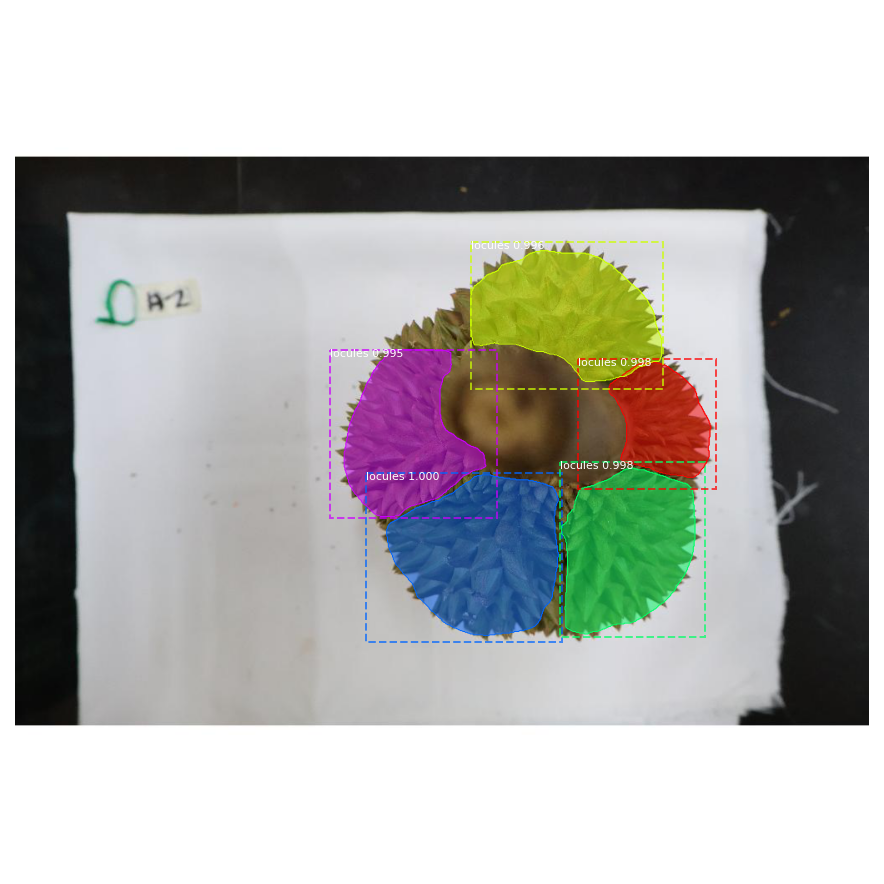

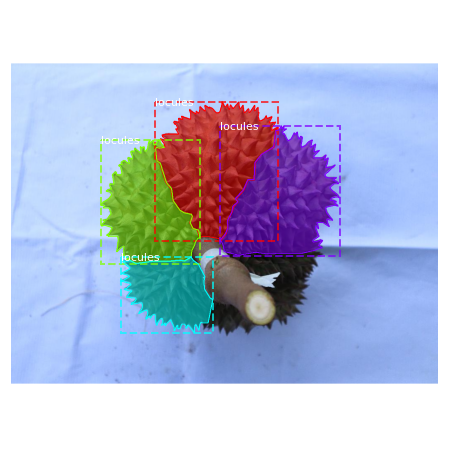

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


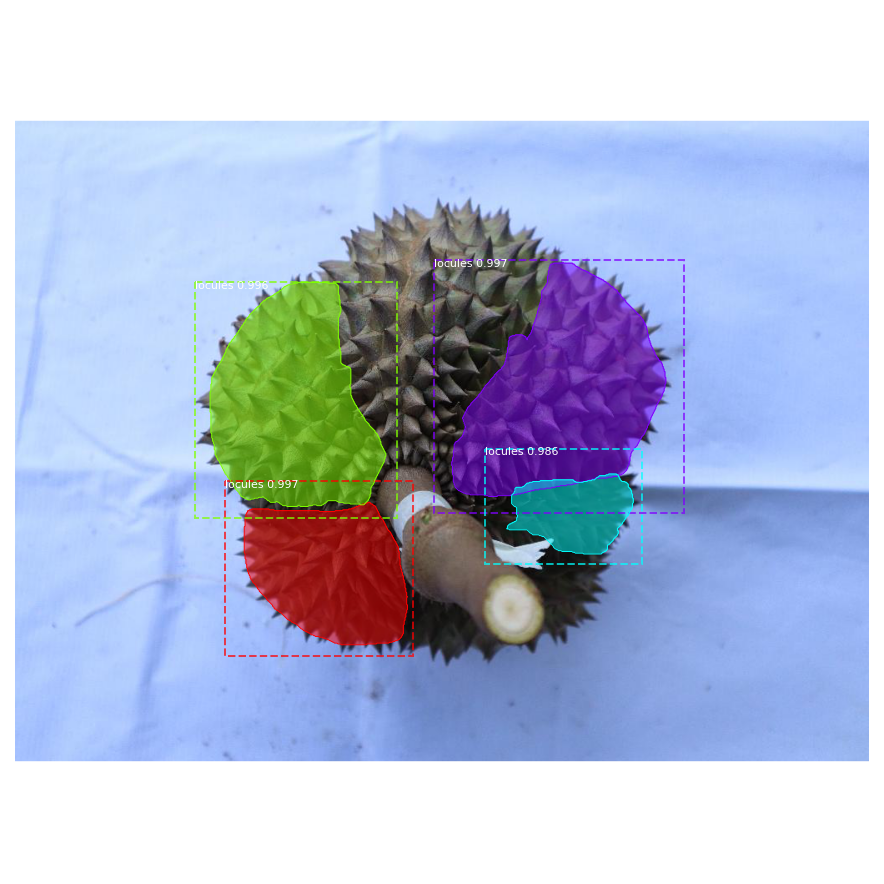

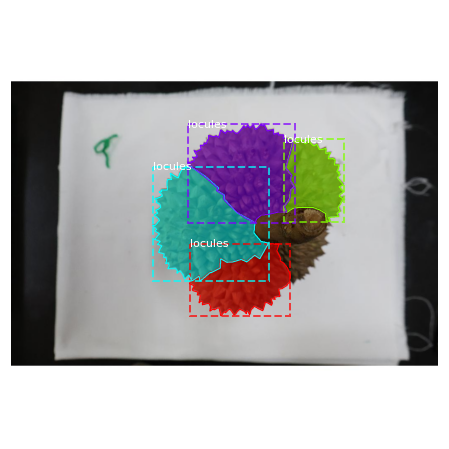

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


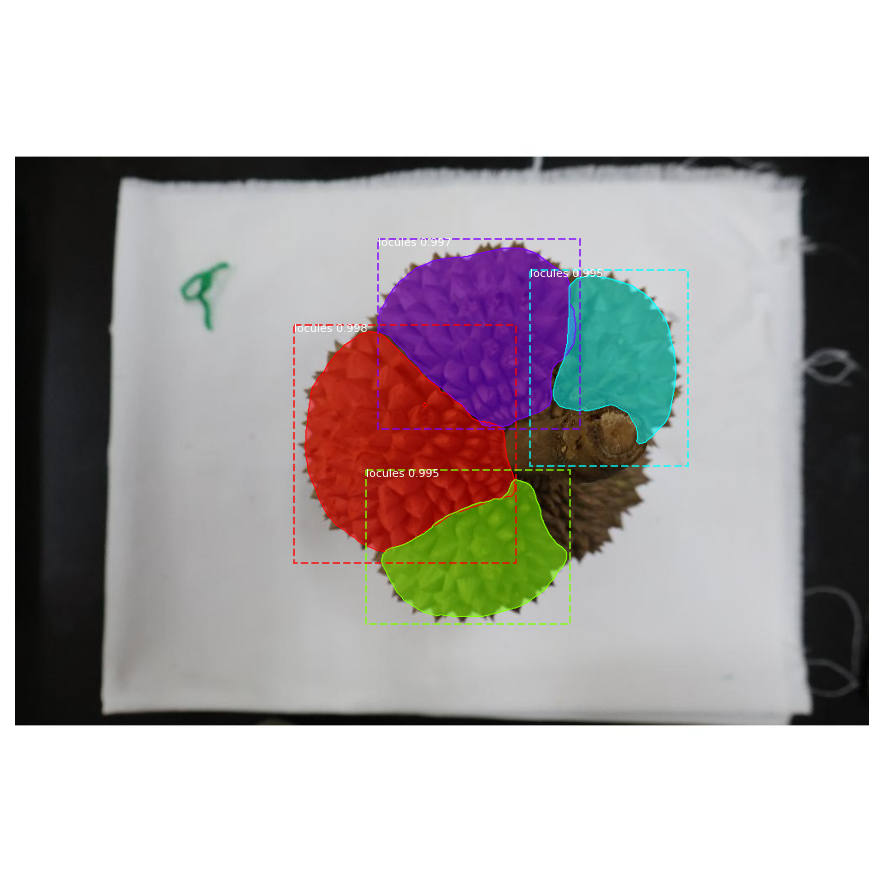

: 

In [ ]:
# Test Infer and show masks around the locules

image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, test_config, image_id)
    
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_test.class_names, figsize=(8, 8))
    results = test_model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_test.class_names, r['scores'])
    
# Compute mAP


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


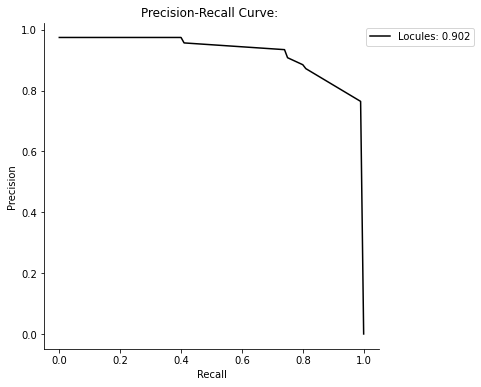

mAP @ IoU=50: 0.9022988513283345
mAP @ IoU=75: 0.8236781640984546
Mean mAP: 0.6353649443165323


In [6]:
%matplotlib inline

import pandas as pd
from utils.performance_metric import compute_performance_metrics, display_bounding_boxes

# Usage
image_ids = dataset_test.image_ids
metrics = compute_performance_metrics(image_ids=image_ids, test_model=test_model, dataset_test=dataset_test, test_config=test_config)

# Display metrics as a Pandas DataFrame
# metrics_df = pd.DataFrame(metrics)


print("mAP @ IoU=50:", metrics["AP_50"])
print("mAP @ IoU=75:", metrics["AP_75"])
print("Mean mAP:", metrics["mAP"])

# Display bounding boxes
# display_bounding_boxes(metrics["image_data"])


In [ ]:
# Export the model to tflite
import tensorflow as tf
from mrcnn import utils
from mrcnn import model as modellib

# Set the path to the .h5 file of the model to be converted

# test_model = tf.keras.models.load_model(TRAINED_MODEL_WEIGHTS_PATH)
test_model = modellib.MaskRCNN(mode="inference", config=test_config, model_dir=MODEL_DIR)
model.load_weights(TRAINED_MODEL_WEIGHTS_PATH, by_name=True)
model.keras_model.save("mask_rcnn_locules", save_format='tf')

# converter = tf.lite.TFLiteConverter.from_keras_model(test_model)
# converter.allow_custom_ops = True
# converter.experimental_new_converter = True
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#     tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# ]

# converter.optimizations = [ tf.lite.Optimize.DEFAULT ]

# tflite_model = converter.convert()


In [ ]:
import json

def save_model(trained_model, out_fname="model.json"):
    jsonObj = trained_model.keras_model.to_json()
    with open(out_fname, "w") as fh:
        fh.write(jsonObj)
 
 
test_model = modellib.MaskRCNN(mode="inference", config=test_config, model_dir=MODEL_DIR)
save_model(test_model, "mymodel.json")

In [ ]:
with open('mymodel.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

In [ ]:
open("model.tflite", "wb").write(tflite_model)